# Notebook for preparing data for spine labelling

In [11]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import csv
%matplotlib inline



In [12]:
sag_path = '/home/donal/PhD/initial_spines/CT_models/data/all_verts/'
coronal_projections_path = './images_coronal/all_projections/'
sag_projections_path = './images_sagittal/all_projections/'
data_list = '/home/donal/PhD/initial_spines/CT_models/data_lists/data_list_all_forviewing.txt'



In [13]:
ordered_verts = ['T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'L1', 'L2', 'L3', 'L4']

## Functions for loading/checking data

In [14]:
def get_centre(pts_file):
    """
    Find centre point of vertebral body from sagittal annotations
    """
    with open(pts_file, 'r') as f:
        text = f.readlines()
        lines = [line.strip() for line in text]
        start = lines.index('{')
        end = lines.index('}')
        points = lines[start+1:end]
        top_y = [float(line.split(' ')[-1]) for line in points[0:10]]
        bot_y = [float(line.split(' ')[-1]) for line in points[19:29]]
        top_y.extend(bot_y)
    return np.mean(top_y)

def check_rejects(pts_dict):
    # Check for overlapping annotations
    reject_list = []
    for key, val in pts_dict.items():
        for vert, elem in val.items():
            # Find nearest centre point
            coords = list(val.values())
            coords.remove(elem)
            zipped_coords = list(zip(*coords))
            near_neigh = sorted(
                list(zipped_coords[-1]), key=lambda x: abs(x-elem[-1]))[0]
            # Find distance between centroid for vert and nearest neighbour
            dist = int(abs(elem[-1]-near_neigh))
            if dist == 0:
                print(key, vert)
                reject_list.append(key)
                continue
    return reject_list

def find_x_val(coronal_pts, tgt):
    """
    Find x val in coronal projection by finding coronal midline
    """
    with open(coronal_pts, 'r') as f:
        text = f.readlines()
        lines = [line.strip() for line in text]
        start = lines.index('{')
        end = lines.index('}')
        points = lines[start+1:end]
        y_vals = [float(line.split(' ')[-1]) for line in points]
        x_vals = [float(line.split(' ')[0]) for line in points]
    # Get top 2 closest values to sag. midpoint (y-axis)
    mini = sorted(y_vals, key=lambda t: abs(t-tgt))[:2]
    idx = [y_vals.index(val) for val in mini]
    select_x = np.asarray(x_vals)[idx]
    del_y = mini[0] - mini[1]
    del_x = select_x[0]-select_x[1]
    if del_x == 0:
        return select_x[0]
    else:
        slope = del_y/del_x
        b = mini[0]-slope*select_x[0]
    #y=mx+b => x = (y-b)/m
    return (tgt-b)/slope

def get_id():
    """
    Collect paths to point files, in a dict
    """
    sag_files = [file for file in os.listdir(sag_path)]
    pts_files = {}
    with open(data_list, 'r') as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines]
        start = lines.index('{')
        end = lines.index('}')
        info_list = lines[start+1:end]
        for line in info_list:
            pts, img = line.split(':')
            if '_Sag_' in pts:
                id_ = pts.split('.')[0].split('_Sag_')[0]
            else:
                id_ = pts.split('.')[0].split('_midline_')[0]

            matched_mip = [filename for filename in os.listdir(
                coronal_projections_path) if id_ in filename]
            for file in matched_mip:
                id_ = file.split('.npy')[0]
                vert_list = list(
                    filter(lambda x: f'{id_}_midline' in x, sag_files))
                if not vert_list:
                    continue
                else:
                    pts_files[id_] = vert_list
    return pts_files

def get_points(pts_files):
    """
     Get coordinates of each vertebral centre point
    """
    pts_dict = {}
    for key, val in pts_files.items():
        name = f'{key}_kj'
        pts_dict[name] = {}
        for elem in val:
            # Find name of vertebra
            name_split = re.findall('[0-9a-zA-Z][^A-Z]*',
                                    os.path.splitext(elem)[0])
            vert = name_split[-1].split('_')[0]
            # Get y-value of centre-point on saggital
            coronal_filename = f'{name}.jpg.pts'
            centre_point = get_centre(os.path.join(sag_path, elem))
            # Get x-value
            x_val = find_x_val(
                f'/home/donal/PhD/initial_spines/CT_models/MIP/data/points/{coronal_filename}', centre_point)
            pts_dict[name][vert] = (x_val, centre_point)

    return pts_dict

## Collect Points 

In [15]:
pts_files = get_id()
print(f'Found {len(list(pts_files.keys()))} points files w/ matching MIP')
pts_dict = get_points(pts_files)
print(f'Found {len(list(pts_dict.keys()))} vertebral annotations.')

Found 353 points files w/ matching MIP
Found 353 vertebral annotations.


## Convert to one-hot encoding

In [16]:
from sklearn.preprocessing import LabelBinarizer

In [17]:
 vert_list = []
# Convert vertebra names to one-hot
for val in pts_dict.values():
    vert_list.extend(list(val.keys()))
all_verts = list(np.unique(vert_list))
enc = LabelBinarizer()
enc.fit(all_verts)
enc.classes_ = ordered_verts
# Check for overlapping annotations
reject_list = set(check_rejects(pts_dict))
# Add key to rejects -- Can't remember why I chose to reject this one...
reject_list.add('23_05_2014_153_Sag')
print(f'Found {len(reject_list)} rejects.')

Found 1 rejects.


## Read pixel info, collected when MIPs were performed

In [18]:
 # Read pixel info
pix_info = pd.read_csv(
    '/home/donal/CT_volumes/pixel_size.csv', index_col='Name')
min_pix = pix_info.loc[:, 'Size (mm)'].min()
print(f'Minimum pixel size across dataset: {min_pix} mm')
print(pix_info.head())

Minimum pixel size across dataset: 0.3125 mm
                                              Size (mm)
Name                                                   
18_03_2015_20150318152008968_SRS00000_mip_WL   0.685000
fr_580_LS_Sag_mip_WL                           0.781250
29_05_2014_60_Sag_mip_WL                       0.781250
fr_560_TS_Sag_mip_WL                           0.701172
06_06_2014_502_LS_Sag_mip_WL                   0.800000


# Prepare images

In [19]:
from ast import literal_eval
import scipy.stats as stats

In [20]:
def prep_images(pts_dict, rejects, pix_info, outpath='./data/annotated_sanity/', plot=False):
    # Prepare data for Train/Test/Val split
    cor_info_csv = './images_coronal/annotation_info.csv'
    sag_info_csv = './images_sagittal/annotation_info.csv'
    clean_path = '/home/donal/PhD/initial_spines/CT_models/FCN/data/clean_data.npz'
    clean_data = np.load(clean_path)
    id_list = [''.join(elem) for elem in clean_data['id']]
    cor_info = pd.read_csv(cor_info_csv)
    sag_info = pd.read_csv(sag_info_csv)
    for key, val in pts_dict.items():
        print(key)
        if key.split('_kj')[0] not in rejects:
            key = key.split('_kj')[0]
            # Check if ID is in clean_data (i.e annotation is ok)
            if key not in id_list:
                print('Issue with image, skipping...')
                continue
            out_img_path = os.path.join(outpath, f'{key}_annotated.tiff')
            # Load projection images
            cor_filename = os.path.join(coronal_projections_path, f'{key}.npy')
            cor_img = np.load(cor_filename)
            sag_filename = os.path.join(sag_projections_path, f'{key}.npy')
            sag_img = np.load(sag_filename)

            # Get info from pre-processing images
            cor = cor_info.loc[cor_info['Name'] == key]
            cor_pad = literal_eval(cor.iloc[0]['Padding'])
            cor_scale = literal_eval(cor.iloc[0]['Pixel Scaling'])
            # Load vert annotations
            vert_dict = {}
            for vert, elem in val.items():
                # Account for resampling to isotropic grid
                x, y = (x*s for x, s in zip(elem, cor_scale))
                y -= cor_pad[1]
                vert_dict[vert] = y
            
            # Convert y coordinate to heatmap
            gt_holder = np.zeros((*cor_img.shape[:2], len(ordered_verts)), dtype=np.int16)
            mask_holder = np.zeros((*cor_img.shape[:2], len(ordered_verts)+1), dtype=np.int16)
            for vert, y in vert_dict.items():
                channel = ordered_verts.index(vert)
                x = np.linspace(0, 626, 626)
                gauss = np.array(stats.norm.pdf(x, y, 10))[..., np.newaxis]
                norm_gauss = (gauss - gauss.min())/(gauss.max()-gauss.min())*626
                # FULL-WIDTH HALF-MAX threshold for classification
                thresh_mask = np.where(norm_gauss >= norm_gauss.max()/2, 1, 0)
                tmp_mask = np.tile(thresh_mask, (1, 452)).astype(np.int16)
                tmp = np.tile(norm_gauss, (1, 452)).astype(np.int16)
                gt_holder[..., channel] = tmp
                mask_holder[..., channel+1] = tmp_mask
            
            # Save heatmap to folder
            np.save(f'./data/heatmaps/{key}.npy', gt_holder)
            np.save(f'./data/masks/{key}.npy', mask_holder)
            
            with open(f'./data/coordinates/{key}.csv', 'w') as f:
                wrt = csv.writer(f, dialect='excel')
                wrt.writerow(['Level', 'Coordinate'])
                for vert, coord in vert_dict.items():
                    wrt.writerow([vert, coord])

            if plot:
                fig, axes = plt.subplots(2, 2, figsize=(10, 10))
                ax = axes.ravel()
                ax[0].axis('off')
                ax[1].axis('off')
                ax[2].axis('off')
                ax[3].axis('off')
                plt.tight_layout()
                ax[0].imshow(cor_img)
                ax[1].imshow(sag_img)
                ax[2].imshow(cor_img)
                ax[2].imshow(np.argmax(mask_holder, axis=-1), alpha=0.5)
                ax[3].imshow(sag_img)
                ax[3].imshow(np.argmax(mask_holder, axis=-1), alpha=0.5)
                for vert, y in vert_dict.items():
                    ax[0].axhline(y, linewidth=2, c='y')
                    ax[0].text(0, y-5, vert, color='w')
                    ax[1].axhline(y, linewidth=2, c='y')
                    ax[1].text(0, y-5, vert, color='w')


                #plt.close()
                break

01_06_2014_363_Sag_kj


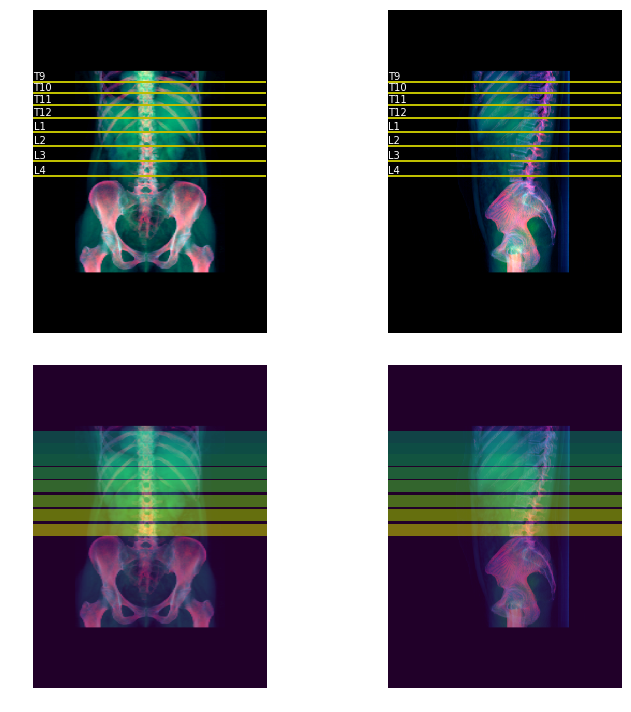

In [21]:
prep_images(pts_dict, reject_list, pix_info, plot=True)